<a href="https://colab.research.google.com/github/450586509/reinforcement-learning-practice/blob/master/08_rl_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 任务 
Hebrew->English machine translation for words and short phrases

In [0]:
# If True, only translates phrases shorter than 20 characters (way easier).
EASY_MODE = True
# Useful for initial coding.
# If false, works with all phrases (please switch to this mode for homework assignment)

MODE = "he-to-en"  # way we translate. Either "he-to-en" or "en-to-he"
# maximal length of _generated_ output, does not affect training
MAX_OUTPUT_LENGTH = 50 if not EASY_MODE else 20
REPORT_FREQ = 100  # how often to evaluate validation score

数据预处理


数据的保存格式为：{ word1:[translation1,translation2,...], word2:[...],...}.

In [0]:
import numpy as np
from collections import defaultdict
word_to_translation = defaultdict(list)  # our dictionary

bos = '_'
eos = ';'

with open("main_dataset.txt") as fin:
    for line in fin:
        en, he = line[:-1].lower().replace(bos, ' ').replace(eos,                                         ' ').split('\t')
        word, trans = (he, en) if MODE == 'he-to-en' else (en, he)
        if len(word) < 3:
            continue
        if EASY_MODE:
            if max(len(word), len(trans)) > 20:
                continue
        word_to_translation[word].append(trans)
print("size = ", len(word_to_translation))

size =  130113


In [0]:
# get all unique lines in source language
all_words = np.array(list(word_to_translation.keys()))
# get all unique lines in translation language
all_translations = np.array(
    [ts for all_ts in word_to_translation.values() for ts in all_ts])

split the dataset


We hold out 10% of all words to be used for validation.

In [0]:
from sklearn.model_selection import train_test_split
train_words, test_words = train_test_split(
    all_words, test_size=0.1, random_state=42)

130113
156326


### Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa. We're gonna need these fellas when we feed training data into model or convert output matrices into english words.

In [0]:
import numpy as np


class Vocab:
    def __init__(self, tokens, bos="__BOS__", eos="__EOS__", sep=''):
        """
        A special class that handles tokenizing and detokenizing
        """
        assert bos in tokens, eos in tokens
        self.tokens = tokens
        self.token_to_ix = {t: i for i, t in enumerate(tokens)}

        self.bos = bos
        self.bos_ix = self.token_to_ix[bos]
        self.eos = eos
        self.eos_ix = self.token_to_ix[eos]
        self.sep = sep

    def __len__(self):
        return len(self.tokens)

    @staticmethod
    def from_lines(lines, bos="__BOS__", eos="__EOS__", sep=''):
        flat_lines = sep.join(list(lines))
        flat_lines = list(flat_lines.split(sep)) if sep else list(flat_lines)
        tokens = list(set(sep.join(flat_lines)))
        tokens = [t for t in tokens if t not in (bos, eos) and len(t) != 0]
        tokens = [bos, eos] + tokens
        return Vocab(tokens, bos, eos, sep)

    def tokenize(self, string):
        """converts string to a list of tokens"""
        tokens = list(filter(len, string.split(self.sep))) \
            if self.sep != '' else list(string)
        return [self.bos] + tokens + [self.eos]

    def to_matrix(self, lines, max_len=None):
        """
        convert variable length token sequences into  fixed size matrix
        example usage:
        >>>print( as_matrix(words[:3],source_to_ix))
        [[15 22 21 28 27 13 -1 -1 -1 -1 -1]
         [30 21 15 15 21 14 28 27 13 -1 -1]
         [25 37 31 34 21 20 37 21 28 19 13]]
        """
        max_len = max_len or max(map(len, lines)) + 2  # 2 for bos and eos

        matrix = np.zeros((len(lines), max_len), dtype='int32') + self.eos_ix
        for i, seq in enumerate(lines):
            tokens = self.tokenize(seq)
            row_ix = list(map(self.token_to_ix.get, tokens))[:max_len]
            matrix[i, :len(row_ix)] = row_ix

        return matrix

    def to_lines(self, matrix, crop=True):
        """
        Convert matrix of token ids into strings
        :param matrix: matrix of tokens of int32, shape=[batch,time]
        :param crop: if True, crops BOS and EOS from line
        :return:
        """
        lines = []
        for line_ix in map(list, matrix):
            if crop:
                if line_ix[0] == self.bos_ix:
                    line_ix = line_ix[1:]
                if self.eos_ix in line_ix:
                    line_ix = line_ix[:line_ix.index(self.eos_ix)]
            line = self.sep.join(self.tokens[i] for i in line_ix)
            lines.append(line)
        return lines

In [0]:

inp_voc = Vocab.from_lines(''.join(all_words), bos=bos, eos=eos, sep='')
out_voc = Vocab.from_lines(''.join(all_translations), bos=bos, eos=eos, sep='')

# Here's how you cast lines into ids and backwards.
batch_lines = all_words[:5]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['אנרכיזם' 'אוטיזם קלאסי' 'אלבדו' 'אלבמה' 'אכילס']

words to ids (0 = bos, 1 = eos):
[[  0  54  28  67 167   7   5  45   1   1   1   1   1   1]
 [  0  54  72  86   7   5  45  88 184 135  54  36   7   1]
 [  0  54 135 169   2  72   1   1   1   1   1   1   1   1]
 [  0  54 135 169 151  41   1   1   1   1   1   1   1   1]
 [  0  54 167   7 135  36   1   1   1   1   1   1   1   1]]

back to words
['אנרכיזם', 'אוטיזם קלאסי', 'אלבדו', 'אלבמה', 'אכילס']


(array([   21.,   112.,  3098.,  8157., 11482., 12556., 11430.,  9568.,
         9254.,  9755., 10299., 11123., 11203., 10840.,  9316.,  7873.,
         6527.,  5523.,  4505.,  3684.]),
 array([ 1.  ,  1.95,  2.9 ,  3.85,  4.8 ,  5.75,  6.7 ,  7.65,  8.6 ,
         9.55, 10.5 , 11.45, 12.4 , 13.35, 14.3 , 15.25, 16.2 , 17.15,
        18.1 , 19.05, 20.  ]),
 <a list of 20 Patch objects>)

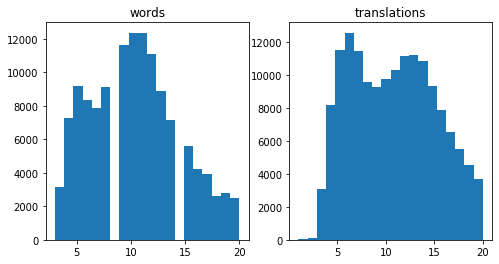

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("words")
plt.hist(list(map(len, all_words)), bins=20)

plt.subplot(1, 2, 2)
plt.title('translations')
plt.hist(list(map(len, all_translations)), bins=20)

### Step 3: deploy encoder-decoder (1 point)

seq2seq模型model提供以下接口：
- model.symbolic_translate(inp, **flags)-> out, logp：输入为：
- model.symbolic_score(inp, out, **flags) -> logp
- model.weights：所有层的权重。

In [0]:
import tensorflow as tf
tf.reset_default_graph()
s = tf.InteractiveSession()

# ^^^ if you get "variable *** already exists": re-run this cell again

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [0]:
import tensorflow as tf
import keras.layers as L

# This code implements a single-GRU seq2seq model. You will have to improve it later in the assignment.
# Note 1: when using several recurrent layers TF can mixed up the weights of different recurrent layers.
# In that case, make sure you both create AND use each rnn/gru/lstm/custom layer in a unique variable scope
# e.g. with tf.variable_scope("first_lstm"): new_cell, new_out = self.lstm_1(...)
#      with tf.variable_scope("second_lstm"): new_cell2, new_out2 = self.lstm_2(...)
# Note 2: everything you need for decoding should be stored in model state (output list of both encode and decode)
# e.g. for attention, you should store all encoder sequence and input mask
# there in addition to lstm/gru states.


class BasicTranslationModel:
    def __init__(self, name, inp_voc, out_voc,
                 emb_size, hid_size,):

        self.name = name
        self.inp_voc = inp_voc
        self.out_voc = out_voc

        with tf.variable_scope(name):
            self.emb_inp = L.Embedding(len(inp_voc), emb_size)
            self.emb_out = L.Embedding(len(out_voc), emb_size)
            self.enc0 = tf.nn.rnn_cell.GRUCell(hid_size)
            self.dec_start = L.Dense(hid_size)
            self.dec0 = tf.nn.rnn_cell.GRUCell(hid_size)
            self.logits = L.Dense(len(out_voc))

            # run on dummy output to .build all layers (and therefore create
            # weights)
            inp = tf.placeholder('int32', [None, None])
            out = tf.placeholder('int32', [None, None])
            h0 = self.encode(inp)
            h1 = self.decode(h0, out[:, 0])
            # h2 = self.decode(h1,out[:,1]) etc.

        self.weights = tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        inp_lengths = infer_length(inp, self.inp_voc.eos_ix)
        inp_emb = self.emb_inp(inp)

        _, enc_last = tf.nn.dynamic_rnn(
            self.enc0, inp_emb,
            sequence_length=inp_lengths,
            dtype=inp_emb.dtype)

        dec_start = self.dec_start(enc_last)
        return [dec_start]

    def decode(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch,n_tokens]
        """

        [prev_dec] = prev_state

        prev_emb = self.emb_out(prev_tokens[:, None])[:, 0]

        new_dec_out, new_dec_state = self.dec0(prev_emb, prev_dec)

        output_logits = self.logits(new_dec_out)

        return [new_dec_state], output_logits

    def symbolic_score(self, inp, out, eps=1e-30, **flags):
        """
        Takes symbolic int32 matrices of hebrew words and their english translations.
        Computes the log-probabilities of all possible english characters given english prefices and hebrew word.
        :param inp: input sequence, int32 matrix of shape [batch,time]
        :param out: output sequence, int32 matrix of shape [batch,time]
        :return: log-probabilities of all possible english characters of shape [bath,time,n_tokens]
        NOTE: log-probabilities time axis  is synchronized with out
        In other words, logp are probabilities of __current__ output at each tick, not the next one
        therefore you can get likelihood as logprobas * tf.one_hot(out,n_tokens)
        """
        first_state = self.encode(inp, **flags)

        batch_size = tf.shape(inp)[0]
        bos = tf.fill([batch_size], self.out_voc.bos_ix)
        first_logits = tf.log(tf.one_hot(bos, len(self.out_voc)) + eps)

        def step(blob, y_prev):
            h_prev = blob[:-1]
            h_new, logits = self.decode(h_prev, y_prev, **flags)
            return list(h_new) + [logits]

        results = tf.scan(step, initializer=list(first_state) + [first_logits],
                          elems=tf.transpose(out))

        # gather state and logits, each of shape [time,batch,...]
        states_seq, logits_seq = results[:-1], results[-1]

        # add initial state and logits
        logits_seq = tf.concat((first_logits[None], logits_seq), axis=0)

        # convert from [time,batch,...] to [batch,time,...]
        logits_seq = tf.transpose(logits_seq, [1, 0, 2])

        return tf.nn.log_softmax(logits_seq)

    def symbolic_translate(
            self,
            inp,
            greedy=False,
            max_len=None,
            eps=1e-30,
            **flags):
        """
        takes symbolic int32 matrix of hebrew words, produces output tokens sampled
        from the model and output log-probabilities for all possible tokens at each tick.
        :param inp: input sequence, int32 matrix of shape [batch,time]
        :param greedy: if greedy, takes token with highest probablity at each tick.
            Otherwise samples proportionally to probability.
        :param max_len: max length of output, defaults to 2 * input length
        :return: output tokens int32[batch,time] and
                 log-probabilities of all tokens at each tick, [batch,time,n_tokens]
        """
        first_state = self.encode(inp, **flags)

        batch_size = tf.shape(inp)[0]
        bos = tf.fill([batch_size], self.out_voc.bos_ix)
        first_logits = tf.log(tf.one_hot(bos, len(self.out_voc)) + eps)
        max_len = tf.reduce_max(tf.shape(inp)[1]) * 2

        def step(blob, t):
            h_prev, y_prev = blob[:-2], blob[-1]
            h_new, logits = self.decode(h_prev, y_prev, **flags)
            y_new = (
                tf.argmax(logits, axis=-1) if greedy
                else tf.multinomial(logits, 1)[:, 0]
            )
            return list(h_new) + [logits, tf.cast(y_new, y_prev.dtype)]

        results = tf.scan(
            step,
            initializer=list(first_state) + [first_logits, bos],
            elems=[tf.range(max_len)],
        )

        # gather state, logits and outs, each of shape [time,batch,...]
        states_seq, logits_seq, out_seq = (
            results[:-2], results[-2], results[-1]
        )

        # add initial state, logits and out
        logits_seq = tf.concat((first_logits[None], logits_seq), axis=0)
        out_seq = tf.concat((bos[None], out_seq), axis=0)
        states_seq = [
            tf.concat((init[None], states), axis=0)
            for init, states in zip(first_state, states_seq)
        ]

        # convert from [time,batch,...] to [batch,time,...]
        logits_seq = tf.transpose(logits_seq, [1, 0, 2])
        out_seq = tf.transpose(out_seq)
        states_seq = [
            tf.transpose(states, [1, 0] + list(range(2, states.shape.ndims)))
            for states in states_seq
        ]

        return out_seq, tf.nn.log_softmax(logits_seq)


### Utility functions ###

def initialize_uninitialized(sess=None):
    """
    Initialize unitialized variables, doesn't affect those already initialized
    :param sess: in which session to initialize stuff. Defaults to tf.get_default_session()
    """
    sess = sess or tf.get_default_session()
    global_vars = tf.global_variables()
    is_not_initialized = sess.run(
        [tf.is_variable_initialized(var) for var in global_vars]
    )
    not_initialized_vars = [
        v for (v, f)
        in zip(global_vars, is_not_initialized)
        if not f
    ]

    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))


def infer_length(seq, eos_ix, time_major=False, dtype=tf.int32):
    """
    compute length given output indices and eos code
    :param seq: tf matrix [time,batch] if time_major else [batch,time]
    :param eos_ix: integer index of end-of-sentence token
    :returns: lengths, int32 vector of shape [batch]
    """
    axis = 0 if time_major else 1
    is_eos = tf.cast(tf.equal(seq, eos_ix), dtype)
    count_eos = tf.cumsum(is_eos, axis=axis, exclusive=True)
    lengths = tf.reduce_sum(tf.cast(tf.equal(count_eos, 0), dtype), axis=axis)
    return lengths


def infer_mask(seq, eos_ix, time_major=False, dtype=tf.float32):
    """
    compute mask given output indices and eos code
    :param seq: tf matrix [time,batch] if time_major else [batch,time]
    :param eos_ix: integer index of end-of-sentence token
    :returns: mask, float32 matrix with '0's and '1's of same shape as seq
    """
    axis = 0 if time_major else 1
    lengths = infer_length(seq, eos_ix, time_major=time_major)
    mask = tf.sequence_mask(lengths, maxlen=tf.shape(seq)[axis], dtype=dtype)
    if time_major:
        mask = tf.transpose(mask)
    return mask


def select_values_over_last_axis(values, indices):
    """
    Auxiliary function to select logits corresponding to chosen tokens.
    :param values: logits for all actions: float32[batch,tick,action]
    :param indices: action ids int32[batch,tick]
    :returns: values selected for the given actions: float[batch,tick]
    """
    assert values.shape.ndims == 3 and indices.shape.ndims == 2
    batch_size, seq_len = tf.shape(indices)[0], tf.shape(indices)[1]
    batch_i = tf.tile(tf.range(0, batch_size)[:, None], [1, seq_len])
    time_i = tf.tile(tf.range(0, seq_len)[None, :], [batch_size, 1])
    indices_nd = tf.stack([batch_i, time_i, indices], axis=-1)

    return tf.gather_nd(values, indices_nd)

In [0]:
model = BasicTranslationModel('model', inp_voc, out_voc,emb_size=64, hid_size=128)

s.run(tf.global_variables_initializer())

In [0]:
# Play around with symbolic_translate and symbolic_score
inp = tf.placeholder_with_default(np.random.randint(
    0, 10, [3, 5], dtype='int32'), [None, None])
out = tf.placeholder_with_default(np.random.randint(
    0, 10, [3, 5], dtype='int32'), [None, None])

# translate inp (with untrained model)
sampled_out, logp = model.symbolic_translate(inp, greedy=False)
print("\nSymbolic_translate output:\n", sampled_out, logp)
print("\nSample translations:\n", s.run(sampled_out))

# score logp(out | inp) with untrained input
logp = model.symbolic_score(inp, out)
print("\nSymbolic_score output:\n", logp)
print("\nLog-probabilities (clipped):\n", s.run(logp)[:, :2, :5])



In [0]:
# Prepare any operations you want here
input_sequence = tf.placeholder('int32', [None, None])
greedy_translations, logp = <build symbolic translations with greedy = True >


def translate(lines):
    """
    You are given a list of input lines. 
    Make your neural network translate them.
    :return: a list of output lines
    """
    # Convert lines to a matrix of indices
    lines_ix = <YOUR CODE >

    # Compute translations in form of indices
    trans_ix = s.run(greedy_translations, { < YOUR CODE - feed dict > })

    # Convert translations back into strings
    return out_voc.to_lines(trans_ix)

In [0]:
print("Sample inputs:", all_words[:3])
print("Dummy translations:", translate(all_words[:3]))

assert isinstance(greedy_translations,
                  tf.Tensor) and greedy_translations.dtype.is_integer, "trans must be a tensor of integers (token ids)"
assert translate(all_words[:3]) == translate(
    all_words[:3]), "make sure translation is deterministic (use greedy=True and disable any noise layers)"
assert type(translate(all_words[:3])) is list and (type(translate(all_words[:1])[0]) is str or type(
    translate(all_words[:1])[0]) is unicode), "translate(lines) must return a sequence of strings!"
print("Tests passed!")